# Training model

## Import libraries

In [1]:
import boto3
import os
import tensorflow as tf
from datetime import datetime
import numpy as np

import pickle

from pathlib import Path

# Importing the required Keras modules containing model and layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    Dropout,
    Flatten,
    MaxPooling2D,
)

import matplotlib.pyplot as plt

import random

## Load data

In [2]:
use_ceph = bool(int(os.getenv("USE_CEPH", 0)))
automation = bool(int(os.getenv("AUTOMATION", 0)))
project_name = os.environ.get("PROJECT_NAME", "elyra-aidevsecops-tutorial")

if automation:

    # Get file path relative to notebook
    raw_dataset_path = str(os.environ.get("DATASET", "data/raw"))

else:

    # Download and store in project's data directory
    directory_path = Path.cwd().parents[0]
    raw_dataset_path = directory_path.joinpath(
        str(os.environ.get("DATASET", "data/raw"))
    )

if use_ceph:

    # Download files from S3
    s3_endpoint_url = os.environ["OBJECT_STORAGE_ENDPOINT_URL"]
    s3_access_key = os.environ["AWS_ACCESS_KEY_ID"]
    s3_secret_key = os.environ["AWS_SECRET_ACCESS_KEY"]
    #     s3_access_key = 'v3FnruQ78kfeULDjejUB'
    #     s3_secret_key= 'kJiDiHXncLJOXbaL7Zeb5Ok+gkLt9sWIa1rWAJa0'
    s3_bucket = os.environ["OBJECT_STORAGE_BUCKET_NAME"]

    # Create an S3 client
    s3 = boto3.client(
        service_name="s3",
        aws_access_key_id=s3_access_key,
        aws_secret_access_key=s3_secret_key,
        endpoint_url=s3_endpoint_url,
    )

    key = f"{project_name}/data/raw/xdata.pkl"
    filename_path = str(f"{raw_dataset_path}/xdata.pkl")
    print(f"Downloading {key} into {filename_path}")
    s3.download_file(Bucket=s3_bucket, Key=key, Filename=filename_path)

    key = f"{project_name}/data/raw/ydata.pkl"
    filename_path = str(f"{raw_dataset_path}/ydata.pkl")
    print(f"Downloading {key} into {filename_path}")
    s3.download_file(Bucket=s3_bucket, Key=key, Filename=filename_path)

    key = f"{project_name}/data/raw/xtestdata.pkl"
    filename_path = str(f"{raw_dataset_path}/xtestdata.pkl")
    print(f"Downloading {key} into {filename_path}")
    s3.download_file(Bucket=s3_bucket, Key=key, Filename=filename_path)

    key = f"{project_name}/data/raw/ytestdata.pkl"
    filename_path = str(f"{raw_dataset_path}/ytestdata.pkl")
    print(f"Downloading {key} into {filename_path}")
    s3.download_file(Bucket=s3_bucket, Key=key, Filename=filename_path)


pkl_file = open(f"{raw_dataset_path}/xdata.pkl", "rb")
x_train = pickle.load(pkl_file)
pkl_file.close()

pkly_file = open(f"{raw_dataset_path}/ydata.pkl", "rb")
y_train = pickle.load(pkly_file)
pkly_file.close()

pklxtest_file = open(f"{raw_dataset_path}/xtestdata.pkl", "rb")
x_test = pickle.load(pklxtest_file)
pklxtest_file.close()

pklytest_file = open(f"{raw_dataset_path}/ytestdata.pkl", "rb")
y_test = pickle.load(pklytest_file)
pklytest_file.close()

## Set parameters

In [3]:
# MNIST dataset parameters.
num_classes = 10  # total classes (0-9 digits).

# Training parameters.
batch_size = 128
display_step = 10

# Network parameters.
conv1_filters = 32  # number of filters for 1st conv layer.
conv2_filters = 64  # number of filters for 2nd conv layer.
fc1_units = 1024  # number of neurons for 1st fully-connected layer.

## Split Data into Train and Test sets

In [4]:
# Convert to float32.
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
# Normalize images value from [0, 255] to [0, 1].
x_train, x_test = x_train / 255.0, x_test / 255.0

# Reshaping the array to 4-dims so that it can work with the Keras API
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

print("x_train shape:", x_train.shape)
print("Number of images in x_train", x_train.shape[0])
print("Number of images in x_test", x_test.shape[0])

x_train shape: (60000, 28, 28, 1)
Number of images in x_train 60000
Number of images in x_test 10000


## Create CNN Model

In [5]:
input_shape = (28, 28, 1)

# Creating a Sequential Model and adding the layers
conv_net = Sequential()
conv_net.add(
    Conv2D(
        conv1_filters,
        kernel_size=(5, 5),
        padding="same",
        activation="relu",
        input_shape=input_shape,
    )
)
conv_net.add(MaxPooling2D(pool_size=(2, 2)))
conv_net.add(
    Conv2D(
        conv2_filters, kernel_size=(3, 3), padding="same", activation="relu"
    )
)
conv_net.add(MaxPooling2D(pool_size=(2, 2)))
conv_net.add(Flatten())  # Flattening the 2D arrays for fully connected layers
conv_net.add(Dense(fc1_units, activation=tf.nn.relu))
conv_net.add(Dropout(0.5))
conv_net.add(Dense(num_classes, activation=tf.nn.softmax))

## Compiling and Fitting the Model

In [6]:
conv_net.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
conv_net.fit(x=x_train, y=y_train, epochs=1)

1875/1875 [==============================] - 118s 63ms/step - loss: 0.1223 - accuracy: 0.9617


In [7]:
conv_net.evaluate(x_test, y_test)

313/313 [==============================] - 5s 16ms/step - loss: 0.0333 - accuracy: 0.9881


[0.03325576335191727, 0.988099992275238]

## Test the model

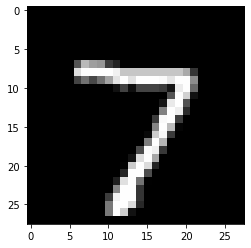

Model prediction: 7


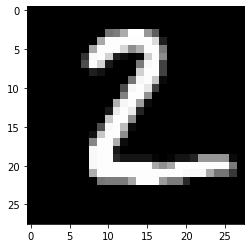

Model prediction: 2


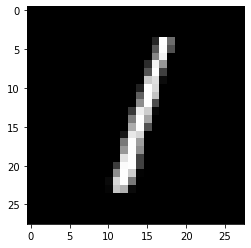

Model prediction: 1


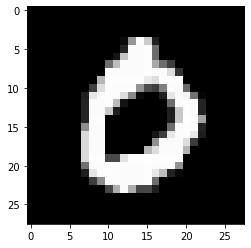

Model prediction: 0


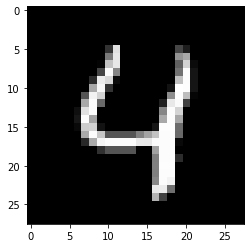

Model prediction: 4


In [8]:
# Visualize predictions.

n_images = 5

# Display image and model prediction.
for i in range(n_images):
    plt.imshow(x_test[i], cmap="gray")
    plt.show()

    prediction = conv_net.predict(x_test[i].reshape(1, 28, 28, 1))
    print("Model prediction: %i" % prediction.argmax())

## Save model

In [9]:
# Save the model to file
# Fetch the Keras session and save the model

time_version = f"{datetime.now():%y%m%d%H%M%S}-{random.getrandbits(64):08x}"

# Path to data
directory_path = Path.cwd().parents[0]
trained_model_path = directory_path.joinpath(
    str(os.environ.get("TRAINED_MODEL_PATH", "models"))
)

tf.keras.models.save_model(
    conv_net,
    f"{trained_model_path}/{time_version}/",
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
)

if automation or use_ceph:
    # Download files from S3
    s3_endpoint_url = os.environ["OBJECT_STORAGE_ENDPOINT_URL"]
    s3_access_key = os.environ["AWS_ACCESS_KEY_ID"]
    s3_secret_key = os.environ["AWS_SECRET_ACCESS_KEY"]
    s3_bucket = os.environ["OBJECT_STORAGE_BUCKET_NAME"]

    # Create an S3 client
    s3 = boto3.client(
        service_name="s3",
        aws_access_key_id=s3_access_key,
        aws_secret_access_key=s3_secret_key,
        endpoint_url=s3_endpoint_url,
    )

    p = Path(f"{trained_model_path}/{time_version}/")
    for child in p.rglob("*"):
        if not child.is_dir():
            store_file_path = str(child).split(str(trained_model_path))[1]
            key = f"{project_name}/models{store_file_path}"
            print(key)
            s3.upload_file(Bucket=s3_bucket, Key=key, Filename=str(child))

INFO:tensorflow:Assets written to: /opt/app-root/src/nb-pr/elyra-aidevsecops-tutorial/models/210722200532-a80b8d818a180895/assets
